In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
data_path = "/content/drive/MyDrive/INFSCI_2125_Final_project/data/cleaned_data"

sat_LU_linkload = pd.read_csv(data_path + "/LU_linkload_sat_2022_cleaned.csv")
sat_LU_od = pd.read_csv(data_path + "/NBT22SAT2b_od_mode_LU_tb_wf_o.csv")

sat_LU_od.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7
0,500,501,0.000000,2.806365,2.434534,1.460321,0.376535,0.000000
1,500,502,0.000000,0.506471,0.649982,0.000000,0.377709,1.084443
2,500,503,0.420431,1.465551,16.017698,6.180745,2.366512,3.403323
3,500,505,4.031680,7.696195,33.955770,21.610695,14.013527,8.229705
4,500,506,0.000088,0.000334,0.234273,0.140889,0.004858,0.017833


In [4]:
# drop unuseful columns
columns_to_drop = ['link', 'line', 'dir', 'order', 'from_asc', 'to_asc']
sat_LU_linkload.drop(columns=columns_to_drop, inplace=True)
sat_LU_linkload.head()

,from_nlc,from_station,to_nlc,to_station,total,early,am_peak,midday,pm_peak,evening,...,0230-0245,0245-0300,0300-0315,0315-0330,0330-0345,0345-0400,0400-0415,0415-0430,0430-0445,0445-0500
0,570,Elephant & Castle LU,628,Lambeth North,11218.636648,192.020084,1141.253832,5357.152937,2239.143080,1464.661554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,628,Lambeth North,747,Waterloo LU,15009.767060,223.628239,1509.902035,7192.564348,3213.877616,1873.957404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,747,Waterloo LU,542,Embankment,37006.983903,325.753342,2908.854362,17288.746625,9113.119974,5054.280257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,542,Embankment,718,Charing Cross LU,43703.138601,358.185435,3175.401077,19789.462189,11176.944333,6232.559915,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,718,Charing Cross LU,674,Piccadilly Circus,50420.108384,424.804831,3521.292343,21616.356946,13160.504933,7555.698682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Check for consistency in node IDs between OD data and topology data
sat_LU_od_nodes = set(sat_LU_od['mode_mnlc_o']).union(set(sat_LU_od['mode_mnlc_d']))
sat_LU_linkload_nodes = set(sat_LU_linkload['from_nlc']).union(set(sat_LU_linkload['to_nlc']))

In [6]:
# Find unmatched nodes between OD and topology data
unmatched_sat_LU_od_nodes = sat_LU_od_nodes - sat_LU_linkload_nodes
unmatched_sat_LU_linkload_nodes = sat_LU_linkload_nodes - sat_LU_od_nodes

# Summarize the findings
unmatched_sat_LU_od_nodes, unmatched_sat_LU_linkload_nodes

(set(), set())

In [7]:
# Extract necessary fields for constructing the network graph
edges = sat_LU_linkload[['from_nlc', 'to_nlc']].drop_duplicates()

# Create a directed graph using NetworkX
graph = nx.DiGraph()

# Add edges to the graph
graph.add_edges_from(edges.values)

# Get positions for the nodes using a layout (e.g., spring layout)
pos = nx.spring_layout(graph)

In [ ]:
# Function to calculate shortest paths and assign demand to paths
def calculate_paths_and_demand(od_data, graph):
    paths_demand = []

    for _, row in od_data.iterrows():
        origin = int(row['mode_mnlc_o'])
        destination = int(row['mode_mnlc_d'])

        # Check if a path exists between the nodes
        if nx.has_path(graph, origin, destination):
            # Find the shortest path
            shortest_path = nx.shortest_path(graph, source=origin, target=destination, weight=None)
            # Aggregate demand over all time bands
            total_demand = row.iloc[2:].sum()
            paths_demand.append({'origin': origin, 'destination': destination,
                                'path': shortest_path, 'total_demand': int(total_demand)})

    # Convert results to a DataFrame
    paths_demand_df = pd.DataFrame(paths_demand)
    return paths_demand_df

# Calculate paths and demand
paths_demand_df = calculate_paths_and_demand(sat_LU_od, graph)

paths_demand_df.head()

,origin,destination,path,total_demand
0,500,501,"[500, 734, 593, 516, 562, 583, 708, 702, 741, ...",7
1,500,502,"[500, 734, 593, 516, 562, 583, 708, 702, 741, ...",2
2,500,503,"[500, 734, 593, 516, 562, 583, 708, 702, 741, ...",29
3,500,505,"[500, 561, 654, 671, 505]",89
4,500,506,"[500, 561, 654, 671, 505, 721, 720, 707, 683, ...",0


In [ ]:
# #	Node	Betweenness
# 1	Green Park	17656.0
# 6 Westminster 9903.0
# 11
# 16
# 21
# 26
# 31
# 36
# 41
#



# Identify the node corresponding to "Green Park"
green_park_node = sat_LU_linkload[sat_LU_linkload['from_station'] == "Green Park"]['from_nlc'].iloc[0]

green_park_node

590

In [ ]:
# Step 1: Handle directly affected demands (origin or destination is Green Park)
directly_affected_od = sat_LU_od[
    (sat_LU_od['mode_mnlc_o'] == green_park_node) |
    (sat_LU_od['mode_mnlc_d'] == green_park_node)
]

# Calculate unmet demand from directly affected ODs
directly_unmet_demand = directly_affected_od.iloc[:, 2:].sum().sum()

# Step 2: Handle indirectly affected demands (remaining OD pairs)
sat_LU_od_after_attack = sat_LU_od[
    ~sat_LU_od['mode_mnlc_o'].isin([green_park_node]) &
    ~sat_LU_od['mode_mnlc_d'].isin([green_park_node])
]

# Create a copy of the graph and remove the "Green Park" node
graph_after_attack = graph.copy()
graph_after_attack.remove_node(green_park_node)

# Recalculate paths and demand for the filtered OD data
affected_paths_demand_df = calculate_paths_and_demand(sat_LU_od_after_attack, graph_after_attack)

# Add status (Unchanged/Unmet) and calculate unmet demand
affected_paths_demand_df['status'] = affected_paths_demand_df['path'].apply(
    lambda x: 'Unchanged' if len(x) > 0 else 'Unmet'
)
affected_paths_demand_df['unmet_demand'] = affected_paths_demand_df.apply(
    lambda row: row['total_demand'] if row['status'] == 'Unmet' else 0, axis=1
)

# Step 3: Combine unmet demands
indirectly_unmet_demand = affected_paths_demand_df['unmet_demand'].sum()
total_unmet_demand = directly_unmet_demand + indirectly_unmet_demand

# Calculate total demand and unmet percentage
total_demand = sat_LU_od.iloc[:, 2:].sum().sum()
unmet_demand_percentage = (total_unmet_demand / total_demand) * 100

# Output the results
total_unmet_demand, unmet_demand_percentage


(81846.0010253594, 2.5145150373471945)

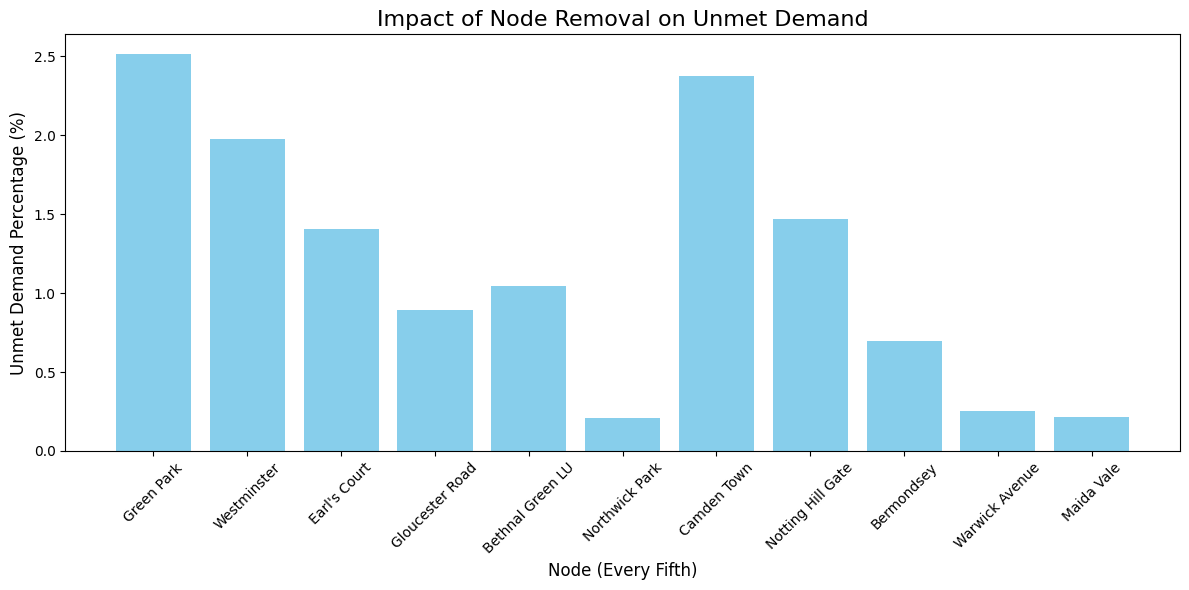

In [ ]:
# Load betweenness data
betweenness_data = pd.read_csv('/content/drive/MyDrive/INFSCI_2125_Final_project/results/lu_betweenness_descending.csv')

# Extract nodes based on your specified rule: first, sixth, eleventh, etc.
nodes_to_attack = betweenness_data.iloc[range(0, 51, 5)]['Node'].tolist()

def simulate_attack(node, linkload_data, od_data, graph):
    node = linkload_data[linkload_data['from_station'] == node]['from_nlc'].iloc[0]
    # Step 1: Directly affected demands
    directly_affected_od = od_data[
        (od_data['mode_mnlc_o'] == node) | (od_data['mode_mnlc_d'] == node)
    ]
    directly_unmet_demand = directly_affected_od.iloc[:, 2:].sum().sum()

    # Step 2: Remaining OD pairs
    remaining_od = od_data[
        (od_data['mode_mnlc_o'] != node) & (od_data['mode_mnlc_d'] != node)
    ]

    # Copy graph and remove the node
    graph_after_attack = graph.copy()
    if node in graph_after_attack.nodes:
        graph_after_attack.remove_node(node)

    # Recalculate paths and unmet demands
    affected_paths_demand_df = calculate_paths_and_demand(remaining_od, graph_after_attack)
    affected_paths_demand_df['status'] = affected_paths_demand_df['path'].apply(
        lambda x: 'Unchanged' if len(x) > 0 else 'Unmet'
    )
    affected_paths_demand_df['unmet_demand'] = affected_paths_demand_df.apply(
        lambda row: row['total_demand'] if row['status'] == 'Unmet' else 0, axis=1
    )

    indirectly_unmet_demand = affected_paths_demand_df['unmet_demand'].sum()

    # Combine direct and indirect unmet demands
    total_unmet_demand = directly_unmet_demand + indirectly_unmet_demand
    return total_unmet_demand

# Calculate total demand
total_demand = sat_LU_od.iloc[:, 2:].sum().sum()

# Simulate attacks for selected nodes
results = []
for node in nodes_to_attack:
    unmet_demand = simulate_attack(node, sat_LU_linkload, sat_LU_od, graph)
    unmet_percentage = (unmet_demand / total_demand) * 100
    results.append({'Node': node, 'Unmet_Percentage': unmet_percentage})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save results to a CSV
results_df.to_csv('/content/drive/MyDrive/INFSCI_2125_Final_project/results/unmet_demand_simulation.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(results_df['Node'], results_df['Unmet_Percentage'], color='skyblue')
plt.xlabel('Node (Every Fifth)', fontsize=12)
plt.ylabel('Unmet Demand Percentage (%)', fontsize=12)
plt.title('Impact of Node Removal on Unmet Demand', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
mtt_LU_linkload = pd.read_csv(data_path + "/LU_linkload_mtt_2022_cleaned.csv")
mtt_LU_od = pd.read_csv(data_path + "/NBT22MON2b_od_mode_LU_tb_wf_o.csv")

mtt_LU_od.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7
0,500,501,0.000000,1.518489,1.701367,1.863230,1.226544,0.024361
1,500,502,0.395940,1.680290,0.143991,1.120521,0.257453,0.000000
2,500,503,2.601695,8.207114,8.007986,3.624526,0.431127,0.000000
3,500,505,8.477784,16.624450,32.777393,53.284817,22.465769,8.465645
4,500,506,0.000051,0.056992,0.172225,0.195404,0.507406,0.001219


In [ ]:
# Check for consistency in node IDs between OD data and topology data
mtt_LU_od_nodes = set(mtt_LU_od['mode_mnlc_o']).union(set(mtt_LU_od['mode_mnlc_d']))
mtt_LU_linkload_nodes = set(mtt_LU_linkload['from_nlc']).union(set(mtt_LU_linkload['to_nlc']))
# Find unmatched nodes between OD and topology data
unmatched_mtt_LU_od_nodes = mtt_LU_od_nodes - mtt_LU_linkload_nodes
unmatched_mtt_LU_linkload_nodes = mtt_LU_linkload_nodes - mtt_LU_od_nodes

# Summarize the findings
unmatched_mtt_LU_od_nodes, unmatched_mtt_LU_linkload_nodes

(set(), set())

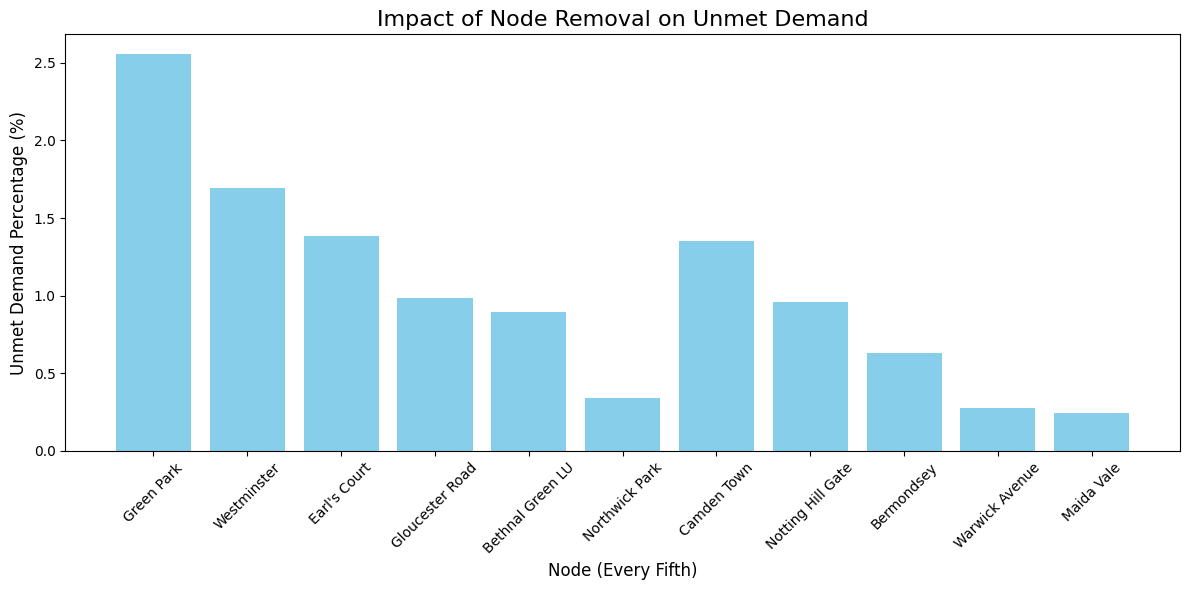

In [ ]:
# Simulate attacks for selected nodes
results = []
for node in nodes_to_attack:
    unmet_demand = simulate_attack(node, mtt_LU_linkload, mtt_LU_od, graph)
    unmet_percentage = (unmet_demand / total_demand) * 100
    results.append({'Node': node, 'Unmet_Percentage': unmet_percentage})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save results to a CSV
results_df.to_csv('/content/drive/MyDrive/INFSCI_2125_Final_project/results/unmet_demand_simulation_mon.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(results_df['Node'], results_df['Unmet_Percentage'], color='skyblue')
plt.xlabel('Node (Every Fifth)', fontsize=12)
plt.ylabel('Unmet Demand Percentage (%)', fontsize=12)
plt.title('Impact of Node Removal on Unmet Demand', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


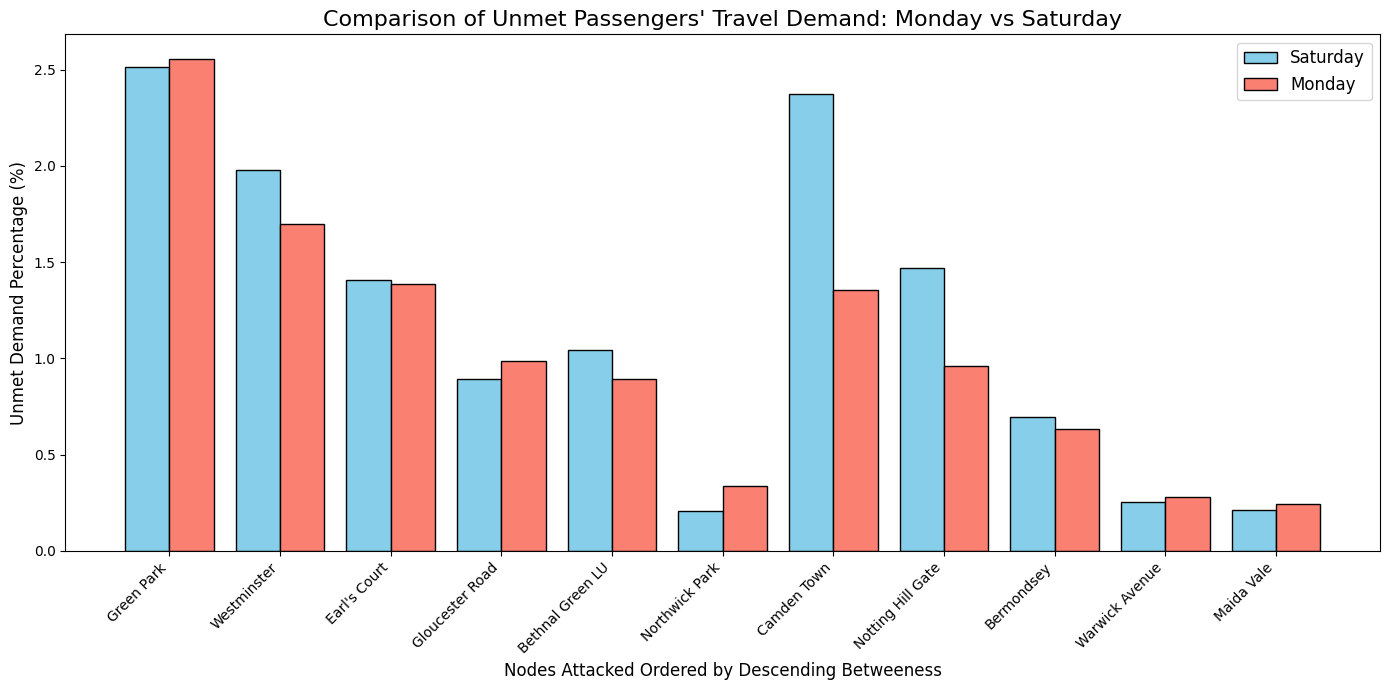

In [ ]:
monday_unmet_demand_df = pd.read_csv('/content/drive/MyDrive/INFSCI_2125_Final_project/results/unmet_demand_simulation_mon.csv')
saturday_unmet_demand_df = pd.read_csv('/content/drive/MyDrive/INFSCI_2125_Final_project/results/unmet_demand_simulation.csv')

# Merge the data on the 'Node' column
merged_data = pd.merge(monday_unmet_demand_df, saturday_unmet_demand_df, on="Node", suffixes=("_Monday", "_Saturday"))

# Plot grouped bar chart
plt.figure(figsize=(14, 7))
x = range(len(merged_data))
bar_width = 0.4

# Plot Saturday data
plt.bar([p - bar_width / 2 for p in x], merged_data["Unmet_Percentage_Saturday"],
        width=bar_width, label="Weekend", color="skyblue", edgecolor="black")

# Plot Monday data
plt.bar([p + bar_width / 2 for p in x], merged_data["Unmet_Percentage_Monday"],
        width=bar_width, label="Weekday", color="salmon", edgecolor="black")

# Add labels and title
plt.xlabel("Nodes Attacked Ordered by Descending Betweeness", fontsize=12)
plt.ylabel("Unmet Demand Percentage (%)", fontsize=12)
plt.title("Comparison of Unmet Passengers' Travel Demand: Monday vs Saturday", fontsize=16)
plt.xticks(x, merged_data["Node"], rotation=45, ha="right", fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the chart
plt.show()

In [1]:
def calculate_path_changes(node, linkload_data, od_data, graph):
    # Map station name to node ID
    node = linkload_data[linkload_data['from_station'] == node]['from_nlc'].iloc[0]

    # Save original paths and lengths
    original_paths = {}
    for _, row in od_data.iterrows():
        origin = row['mode_mnlc_o']
        destination = row['mode_mnlc_d']
        if nx.has_path(graph, origin, destination):
            original_paths[(origin, destination)] = nx.shortest_path_length(graph, source=origin, target=destination)

    # Copy graph and remove the node
    graph_after_attack = graph.copy()
    if node in graph_after_attack.nodes:
        graph_after_attack.remove_node(node)

    # **Filter OD data to exclude trips involving the removed node**
    filtered_od_data = od_data[
        (od_data['mode_mnlc_o'] != node) & (od_data['mode_mnlc_d'] != node)
    ]

    # Save new paths and lengths
    new_paths = {}
    for (origin, destination) in original_paths.keys():
        if (origin != node and destination != node) and nx.has_path(graph_after_attack, origin, destination):
            new_paths[(origin, destination)] = nx.shortest_path_length(graph_after_attack, source=origin, target=destination)
        else:
            new_paths[(origin, destination)] = float('inf')  # Mark as unreachable

    # Calculate path changes
    total_demand = filtered_od_data.iloc[:, 2:].sum().sum()
    increased_path_count = 0
    total_extra_stops = 0
    affected_demand = 0

    for _, row in filtered_od_data.iterrows():
        origin = row['mode_mnlc_o']
        destination = row['mode_mnlc_d']
        demand = row.iloc[2:].sum()
        if (origin, destination) in original_paths:
            original_length = original_paths[(origin, destination)]
            new_length = new_paths[(origin, destination)]
            if new_length > original_length:
                increased_path_count += 1
                total_extra_stops += (new_length - original_length) * demand
                affected_demand += demand

    # Calculate metrics
    percentage_affected = (affected_demand / total_demand) * 100 if total_demand > 0 else 0
    average_extra_stops = total_extra_stops / affected_demand if affected_demand > 0 else 0

    return percentage_affected, average_extra_stops


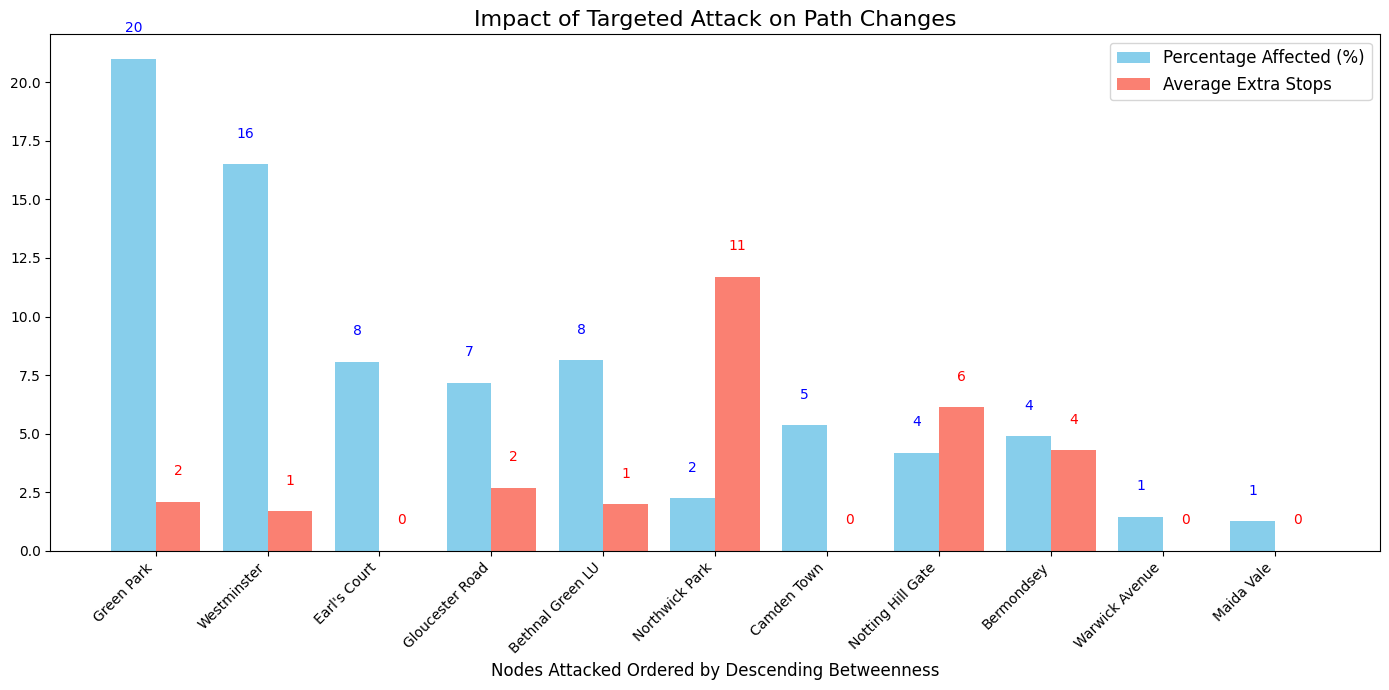

In [ ]:
# Load data
path_change_data_path = "/content/drive/MyDrive/INFSCI_2125_Final_project/results/path_changes.csv"
path_change_df = pd.read_csv(path_change_data_path)

# Replace inf values with 0 in the dataset
path_change_df['Percentage_Affected'] = path_change_df['Percentage_Affected'].replace(np.inf, 0)
path_change_df['Average_Extra_Stops'] = path_change_df['Average_Extra_Stops'].replace(np.inf, 0)

# Create positions for grouped bars
x = np.arange(len(path_change_df['Node']))  # the label locations
bar_width = 0.4  # Width of the bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot Percentage Affected
bars1 = ax.bar(x - bar_width/2, path_change_df['Percentage_Affected'], bar_width,
               label='Percentage Affected (%)', color='skyblue')

# Plot Average Extra Stops
bars2 = ax.bar(x + bar_width/2, path_change_df['Average_Extra_Stops'], bar_width,
               label='Average Extra Stops', color='salmon')

# Add labels, title, and legend
ax.set_xlabel("Nodes Attacked Ordered by Descending Betweenness", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.set_title("Impact of Targeted Attack on Path Changes", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(path_change_df['Node'], rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=12)

# Annotate Percentage Affected bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)),
            ha='center', va='bottom', fontsize=10, color='blue')

# Annotate Average Extra Stops bars
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)),
            ha='center', va='bottom', fontsize=10, color='red')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
